### Importing libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from Functions import anoamly_detection
from main import OptimizingPlacement

In [2]:
placement = OptimizingPlacement()
anomaly_detection = anoamly_detection.AnomalyDetection()

In [3]:
file_name = os.getenv('file_name')
sensor_data = os.getenv("folder_name")
zipped_file = os.getenv("ziped_file")
output_dir = os.getenv('sensor_heatmaps')
video_output = os.getenv('temperature_output')

In [4]:
combined_data, keys_list = placement.extracting_files(zipped_file, sensor_data)

In [5]:
combined_data.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-05-14 02:18:22,15.25,92.8,047D6,047D6 T/RH IP67
1,2024-05-04 21:21:36,13.95,71,047D6,047D6 T/RH IP67
2,2024-05-04 21:26:37,13.65,71.8,047D6,047D6 T/RH IP67
3,2024-05-04 21:31:35,13.4,72.6,047D6,047D6 T/RH IP67
4,2024-05-04 21:36:36,13.4,73.4,047D6,047D6 T/RH IP67


In [6]:
placement.heatmap_video_gen(combined_data, output_dir, video_output)

'Successfully generated the heatmap video.'

In [7]:
combined_data.isnull().sum()

Time              0
Temperature    9351
Humidity       9351
Sensor ID         0
Sensor Name       0
dtype: int64

In [8]:
combined_data['Humidity'] = combined_data['Humidity'].astype('float')
combined_data['Temperature'] = combined_data['Temperature'].astype('float')

In [9]:
combined_data['Day'] = pd.DatetimeIndex(combined_data['Time']).day
combined_data['Time_Instance'] = pd.DatetimeIndex(combined_data['Time']).time
combined_data['Year'] = pd.DatetimeIndex(combined_data['Time']).year
combined_data['Month'] = pd.DatetimeIndex(combined_data['Time']).month

In [10]:
combined_data['flag'] = combined_data.isna().any(axis=1).astype(int)

In [12]:
final_dataset = placement.replacing_missing_values(combined_data)

Epoch 1/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 8.2780 - val_loss: 5.1169
Epoch 2/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 5.2871 - val_loss: 5.3611
Epoch 3/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 5.0734 - val_loss: 5.3963
Epoch 4/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.9687 - val_loss: 7.1886
Epoch 5/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.8342 - val_loss: 5.0100
Epoch 6/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.8901 - val_loss: 4.7865
Epoch 7/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.7444 - val_loss: 4.7290
Epoch 8/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.6718 - val_loss: 4.8297
Epoch 9/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.6395 - val_loss: 4.9137
Epoch 10/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.6527 - val_loss: 4.6582
Epoch 11/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 4.5775 - val_loss: 4.6505
Epoch 12/20
8008/8008

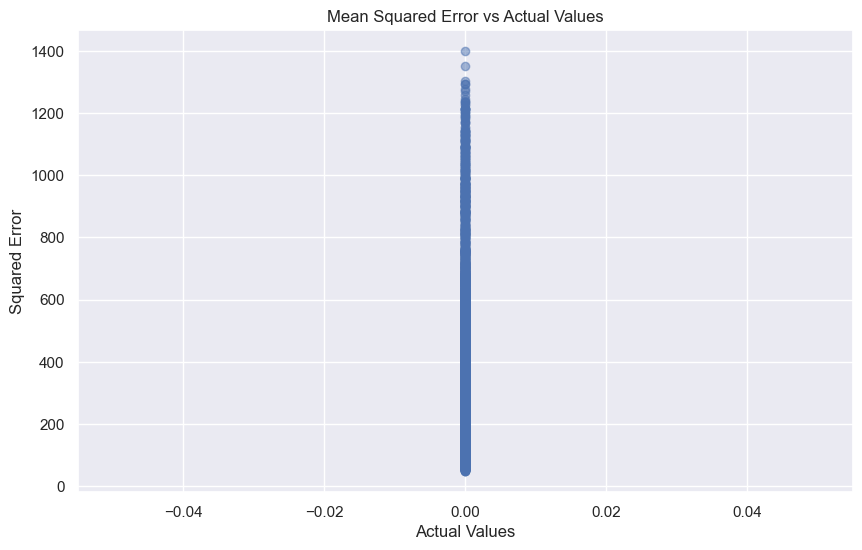

Mean Squared Error (MSE): 342.72648646134104


In [70]:
actual_values = combined_data[combined_data['flag'] == 1]['Temperature'].values
actual_values_clean = np.nan_to_num(actual_values, nan=0.0)

predicted_values = final_dataset[final_dataset['flag'] == 1]['Temperature'].values

# Calculate squared errors
squared_errors = (predicted_values - actual_values_clean) ** 2

# Plot squared errors against actual values
plt.figure(figsize=(10, 6))
plt.scatter(actual_values_clean, squared_errors, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Squared Error')
plt.title('Mean Squared Error vs Actual Values')
plt.grid(True)
plt.show()

# Calculate Mean Squared Error
mse = np.mean(squared_errors)
print(f"Mean Squared Error (MSE): {mse}")

In [13]:
final_dataset.to_csv('Combined_Data.csv', index=False)

In [53]:
final_dataset.iloc[1002]

Time             2024-05-07 10:44:38
Temperature                     25.4
Humidity                        51.5
Sensor ID                      047D6
Sensor Name          047D6 T/RH IP67
Day                                7
Time_Instance               10:44:38
Year                            2024
Month                              5
flag                               0
Name: 1002, dtype: object

In [45]:
final_dataset[(final_dataset['Sensor ID'] == '047D6') & (final_dataset['Day'] == 7) & (final_dataset['flag'] == 1)]

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag
987,2024-05-07 09:29:43,21.66,57.38,047D6,047D6 T/RH IP67,7,09:29:43,2024,5,1
1001,2024-05-07 10:39:40,24.56,51.77,047D6,047D6 T/RH IP67,7,10:39:40,2024,5,1
4528,2024-05-07 15:04:30,28.02,32.79,047D6,047D6 T/RH IP67,7,15:04:30,2024,5,1
4635,2024-05-07 22:59:12,14.54,78.92,047D6,047D6 T/RH IP67,7,22:59:12,2024,5,1


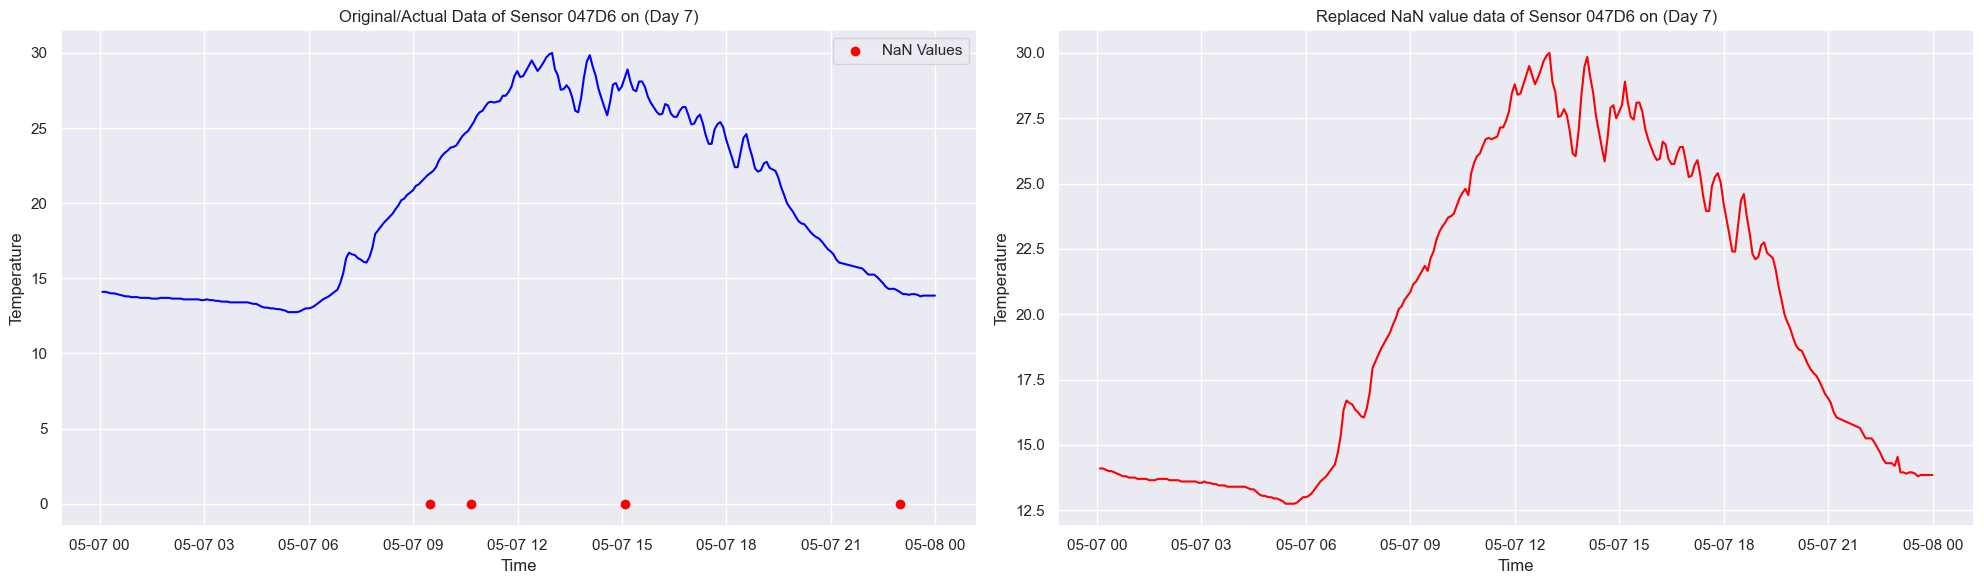

In [43]:
sample_data = combined_data[combined_data['Sensor ID'] == '047D6']
sample_final_data = final_dataset[final_dataset['Sensor ID'] == '047D6']

Non_Empty_data = sample_data[sample_data['Day'] == 7]
final_days = sample_final_data[sample_final_data['Day'] == 7]

Non_Empty_data = Non_Empty_data.sort_values(by='Time')
final_days = final_days.sort_values(by='Time')

# Identify NaN values
nan_indices = Non_Empty_data[Non_Empty_data['Temperature'].isna()].index

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the first DataFrame
sns.lineplot(ax=axes[0], x='Time', y='Temperature', data=Non_Empty_data, color='blue')
axes[0].set_title('Original/Actual Data of Sensor 047D6 on (Day 7)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Temperature')

# Highlight NaN values
axes[0].scatter(Non_Empty_data.loc[nan_indices, 'Time'], [0]*len(nan_indices), color='red', marker='o', label='NaN Values')
axes[0].legend()

# Plot the second DataFrame
sns.lineplot(ax=axes[1], x='Time', y='Temperature', data=final_days, color='red')
axes[1].set_title('Replaced NaN value data of Sensor 047D6 on (Day 7)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Temperature')

# Display the plots
plt.tight_layout()
plt.show()

In [14]:
final_dataset[final_dataset['flag'] == 1].head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag
358,2024-05-05 05:01:20,9.22,83.65,047D6,047D6 T/RH IP67,5,05:01:20,2024,5,1
851,2024-05-20 08:31:34,13.92,84.14,047D6,047D6 T/RH IP67,20,08:31:34,2024,5,1
987,2024-05-07 09:29:43,21.66,57.38,047D6,047D6 T/RH IP67,7,09:29:43,2024,5,1
1001,2024-05-07 10:39:40,24.56,51.77,047D6,047D6 T/RH IP67,7,10:39:40,2024,5,1
1038,2024-05-20 15:01:20,30.18,45.32,047D6,047D6 T/RH IP67,20,15:01:20,2024,5,1


In [15]:
anomalies_list = []
temperature_color = 'green'
humidity_color = 'blue'

for sensor_id, sensor_data in final_dataset.groupby('Sensor ID'):
    sensor_anomalies = anomaly_detection.detect_anomalies(sensor_data, sensor_id, temperature_color, humidity_color)
    anomalies_list.append(sensor_anomalies)

all_anomalies = pd.concat(anomalies_list)

In [16]:
non_anomalous_data = all_anomalies[(all_anomalies['Temperature_anomaly'] == 0) & (all_anomalies['Humidity_anomaly'] == 0)]

X_train = non_anomalous_data[['Temperature', 'Humidity']]
y_train_temp = non_anomalous_data['Temperature']
y_train_humidity = non_anomalous_data['Humidity']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [17]:
mlp_temp = anomaly_detection.training_anomaly_model(X_train_scaled, y_train_temp, '', 'temperature')

Epoch 1/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 10.4222 - val_loss: 6.3223e-04
Epoch 2/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 993us/step - loss: 0.0022 - val_loss: 4.0741e-04
Epoch 3/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 988us/step - loss: 0.0019 - val_loss: 0.0037
Epoch 4/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 985us/step - loss: 0.0014 - val_loss: 4.8126e-05
Epoch 5/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 978us/step - loss: 0.0016 - val_loss: 1.5395e-05
Epoch 6/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 982us/step - loss: 0.0014 - val_loss: 1.2881e-05
Epoch 7/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 981us/step - loss: 9.4860e-04 - val_loss: 4.2696e-06
Epoch 8/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 981us/step - loss: 0.0014 - val_loss: 6.9824e-05
Epoch 9/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 993us/step - loss: 0.0012 - val_loss: 7.8450e-06
Epoch 10/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 978us/step - loss: 9.7977e-04 - val_loss: 0.0176
Epoch 11/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 980us/step - l

In [18]:
mlp_humidity = anomaly_detection.training_anomaly_model(X_train_scaled, '', y_train_humidity, 'humidity')

Epoch 1/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 7s 978us/step - loss: 219.5046 - val_loss: 0.0068
Epoch 2/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0129 - val_loss: 4.4276e-04
Epoch 3/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 1000us/step - loss: 0.0133 - val_loss: 0.0015
Epoch 4/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0128 - val_loss: 7.6600e-04
Epoch 5/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0093 - val_loss: 0.0026
Epoch 6/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0125 - val_loss: 3.7648e-04
Epoch 7/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0133 - val_loss: 1.1188e-04
Epoch 8/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0104 - val_loss: 7.1128e-05
Epoch 9/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0094 - val_loss: 0.0806
Epoch 10/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.0112 - val_loss: 9.7485e-04
Epoch 11/20
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 6s 996us/step - loss: 0.0080 - val_loss: 0.02

In [19]:
anomalies = all_anomalies[(all_anomalies['Temperature_anomaly'] == 1) & (all_anomalies['Humidity_anomaly'] == 1)].copy()

X_anomalies = anomalies[['Temperature', 'Humidity']]
X_anomalies_scaled = scaler.transform(X_anomalies)

anomalies.loc[anomalies['Temperature_anomaly'] == 1, 'Temperature'] = 0
anomalies.loc[anomalies['Humidity_anomaly'] == 1, 'Humidity'] = 0

In [20]:
anomalies['Temperature'] = np.round(mlp_temp.predict(X_anomalies_scaled), 2)
anomalies['Humidity'] = np.round(mlp_humidity.predict(X_anomalies_scaled), 2)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [21]:
all_anomalies.update(anomalies[['Temperature', 'Humidity']])
final_processed_data = all_anomalies.copy()

# final_anomalies = final_processed_data[(final_processed_data['Temperature_anomaly'] == 1) & (final_processed_data['Humidity_anomaly'] == 1)]

In [22]:
final_processed_data[(final_processed_data['Temperature_anomaly'] == 1) & (final_processed_data['Humidity_anomaly'] == 1)].head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag,Temperature_anomaly,Humidity_anomaly
75823,2024-05-20 12:18:36,33.849998,31.420000,0474D,0474D T/RH IP67,20,12:18:36,2024,5,0,1,1
75873,2024-05-20 13:18:34,33.900002,29.629999,0474D,0474D T/RH IP67,20,13:18:34,2024,5,0,1,1
75877,2024-05-20 13:38:33,32.599998,28.780001,0474D,0474D T/RH IP67,20,13:38:33,2024,5,0,1,1
232588,2024-04-30 12:18:06,31.549999,34.000000,04750,04750 T/RH IP67,30,12:18:06,2024,4,0,1,1
232590,2024-04-30 12:28:04,31.600000,34.299999,04750,04750 T/RH IP67,30,12:28:04,2024,4,0,1,1


In [23]:
lastday = final_processed_data['Time'].max().date()
last_day_records = final_processed_data[final_processed_data['Time'].dt.date == lastday]

sensor_sample_data = combined_data[combined_data['Time'].dt.date == lastday]

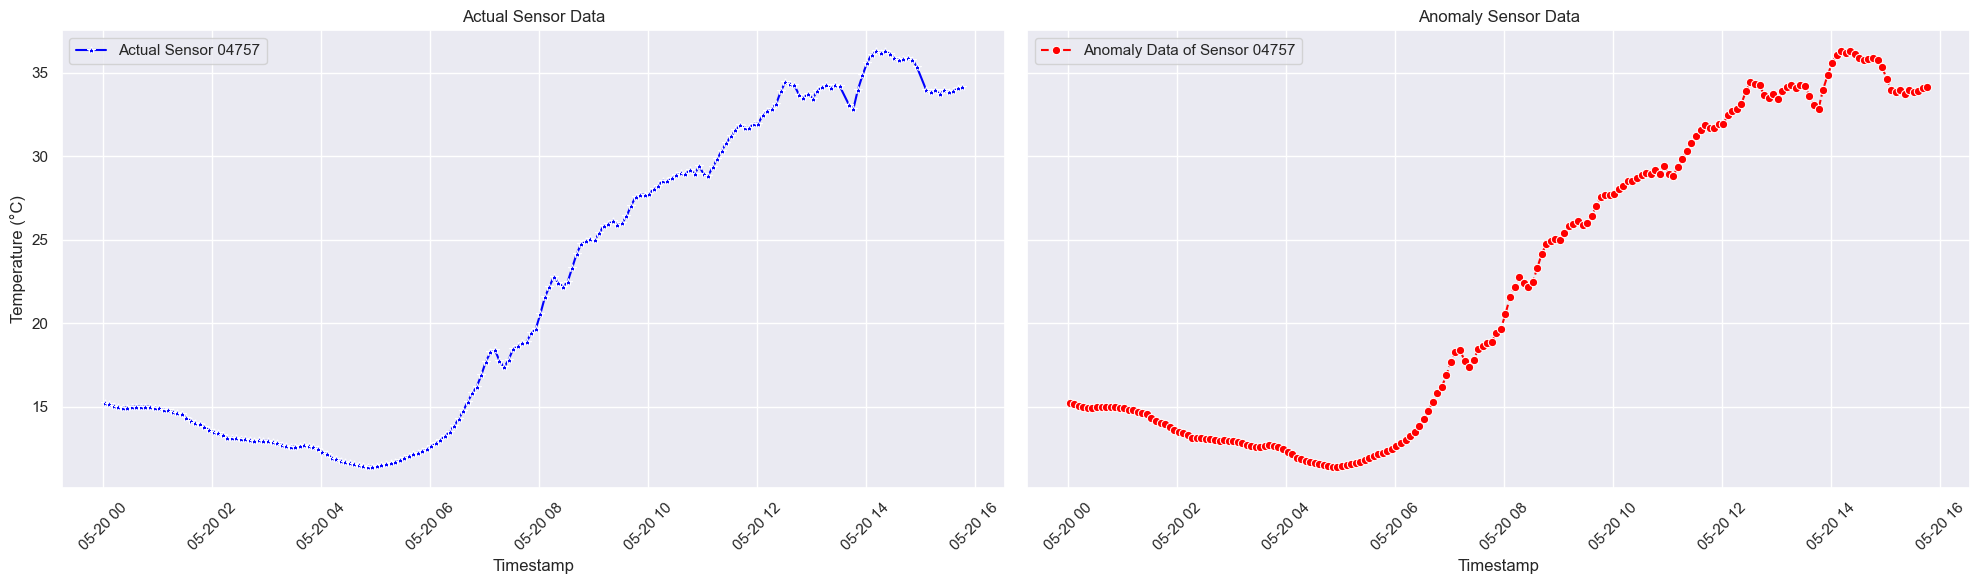

In [24]:
# Set style
sns.set(style="darkgrid")

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Original data
sensor_data = sensor_sample_data[sensor_sample_data['Sensor ID'] == '04757']
sns.lineplot(ax=axs[0], x='Time', y='Temperature', data=sensor_data, 
             marker='*', color='blue',
             label='Actual Sensor 04757')

# Filtered data
filtered_sensor_data = last_day_records[last_day_records['Sensor ID'] == '04757']
sns.lineplot(ax=axs[1], x='Time', y='Temperature', data=filtered_sensor_data, 
             marker='o', color='red',
             linestyle='--', label='Anomaly Data of Sensor 04757')

# Titles and labels
axs[0].set_title('Actual Sensor Data')
axs[1].set_title('Anomaly Sensor Data')

for ax in axs:
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Temperature (°C)')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Compare/original_and_filtered_plots_side_by_side.png')
plt.show()

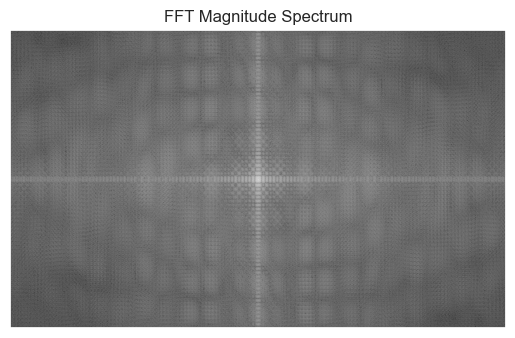

In [25]:
image = cv2.imread('sensor_heatmaps/heatmap_5.png', cv2.IMREAD_GRAYSCALE)

image_float32 = np.float32(image)
image_normalized = image_float32 / 255.0


fft_image = np.fft.fft2(image_normalized)

fft_shifted = np.fft.fftshift(fft_image)

magnitude_spectrum = 20 * np.log(np.abs(fft_shifted))

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('FFT Magnitude Spectrum'), 
plt.xticks([]), 
plt.yticks([])
plt.show()
